In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from statsmodels.tsa.deterministic import DeterministicProcess
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import itertools

C:\Users\Engin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Verinin yüklenmesi 

In [2]:
data=pd.read_csv("https://data.ibb.gov.tr/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/db9c7fb3-e7f9-435a-92f4-1b917e357821/download/traffic_density_202001.csv")

# Verinin incelenmesi

Veri bir zaman serisi. Düzenli aralıklar ile belirli noktalardaki trafik ölçümleri yapılmış. 'LONGITUDE' ve 'LATITUDE' lokasyonun koordinatlarını, 'GEOHASH' kolonu konuma özel kod.

In [3]:
data.head()

,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2020-01-01 00:00:00,28.811646,41.080627,sxk3xw,135,18,81,132
1,2020-01-01 00:00:00,29.108276,40.987244,sxk9nm,143,10,73,162
2,2020-01-01 00:00:00,29.097290,41.003723,sxk9q0,128,6,50,110
3,2020-01-01 00:00:00,28.679810,40.998230,sxk3hx,111,22,68,101
4,2020-01-01 00:00:00,28.020630,41.042175,sx7cmx,99,99,99,1


Verinin incelemesini ve görselleştirmesini yapabilmek amacıyla veriyi tek bir lokasyona indirgedim.

In [4]:
data1=data[data['GEOHASH']=='sxk9bk']
data1.head()

,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
245,2020-01-01 00:00:00,28.844604,41.113586,sxk9bk,85,13,61,58
3788,2020-01-01 01:00:00,28.844604,41.113586,sxk9bk,78,16,58,35
6176,2020-01-01 02:00:00,28.844604,41.113586,sxk9bk,104,27,64,23
7066,2020-01-01 03:00:00,28.844604,41.113586,sxk9bk,91,26,63,13
10767,2020-01-01 04:00:00,28.844604,41.113586,sxk9bk,96,54,66,13


İleride kuracağım model için kaydedilen araç sayıları ve zaman bilgileri gerekli.

In [5]:
data1=data1[['DATE_TIME','NUMBER_OF_VEHICLES']]
data1.head()

,DATE_TIME,NUMBER_OF_VEHICLES
245,2020-01-01 00:00:00,58
3788,2020-01-01 01:00:00,35
6176,2020-01-01 02:00:00,23
7066,2020-01-01 03:00:00,13
10767,2020-01-01 04:00:00,13


Veride null değer bulunmamakta ama daha sonra incelemelerimizi yapabilmek için string olan 'DATE_TIME' kolonunu datetime olarak çevirmemiz gerekli. 

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 245 to 1674140
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DATE_TIME           742 non-null    object
 1   NUMBER_OF_VEHICLES  742 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 17.4+ KB


In [7]:
data1['DATE_TIME'] = pd.to_datetime(data1['DATE_TIME'])
data1.index=data1['DATE_TIME']
data1=data1.sort_index(axis=0)
data1=data1.drop(['DATE_TIME'],axis=1)
data1.head()

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01 00:00:00,58
2020-01-01 01:00:00,35
2020-01-01 02:00:00,23
2020-01-01 03:00:00,13
2020-01-01 04:00:00,13


In [8]:
data1.describe()

,NUMBER_OF_VEHICLES
count,742.000000
mean,86.729111
std,42.728319
min,1.000000
25%,56.000000
50%,86.500000
75%,122.000000
max,179.000000


<AxesSubplot:xlabel='DATE_TIME'>

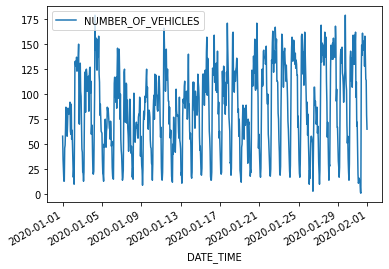

In [9]:
data1.plot()

# Eksik değer kontrolü

In [10]:
nan = data1['NUMBER_OF_VEHICLES'].isnull().values.any()
nan

False

Veri setinde null değer olmamasına rağmen eksik saatler bulunmakta. Yani veri setinde boşluuklar bulunmakta.

In [11]:
_range = pd.date_range(start="2020-01-01 00:00:00", end="2020-01-31 23:00:00", freq='H')
lis=_range.difference(data1.index)
lis

DatetimeIndex(['2020-01-26 09:00:00', '2020-01-26 12:00:00'], dtype='datetime64[ns]', freq=None)

# Eksik değerlerin doldurulması

Sarimax modeli verideki boşluklar ile çalışabilmektedir ama biz diğer eksik değer doldurma yöntemlerini de deneyerek en iyi sonucu bulmaya çalışalım.

In [12]:
data1=data1.asfreq('H')


In [13]:
nan = data1.isnull().values.any()
nan

True

<AxesSubplot:xlabel='DATE_TIME'>

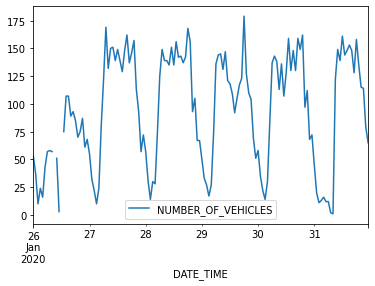

In [14]:
data1[600:].plot()

Şu anda veride eksik değerler bulunmakta. Bunları nasıl doldurabileceğimize bakalım

## 1. ortalama değer 

Çalıştığımız veri seti zaman serisi olduğundan dolayı yakın zamandaki veriler birbirleri ile benzerlikler göstermektedir. Eksik değerleri üst ve alt değerlerinin ortalaması ile doldurabiliriz.

In [15]:
mean=data2.copy()

NameError: name 'data2' is not defined

In [16]:
y = data1.fillna((data1.bfill()+data1.ffill())/2)

In [24]:
 for i in lis:
    index=mean.index.get_loc(i)
    if np.isnan(mean.iloc[index+1]['NUMBER_OF_VEHICLES']) or np.isnan(mean.iloc[index-1]['NUMBER_OF_VEHICLES']):
        
        y=index+1
        z=index-1
        if np.isnan(mean.iloc[y]['NUMBER_OF_VEHICLES']):
            y=index+1
            while np.isnan(mean.iloc[y]['NUMBER_OF_VEHICLES']):
                y=y+1
        if np.isnan(mean.iloc[z]['NUMBER_OF_VEHICLES']):
            z=index-1
            while np.isnan(mean.iloc[z]['NUMBER_OF_VEHICLES']):
                z=z-1
        ort=(mean.iloc[y]['NUMBER_OF_VEHICLES'] + mean.iloc[z]['NUMBER_OF_VEHICLES'])/2 
        mean.iloc[index]['NUMBER_OF_VEHICLES']=ort
        
    else:
        ort=(mean.iloc[index+1]['NUMBER_OF_VEHICLES']+mean.iloc[index-1]['NUMBER_OF_VEHICLES'])/2
        mean.iloc[index]['NUMBER_OF_VEHICLES']=ort


In [17]:
nan = y['NUMBER_OF_VEHICLES'].isnull().values.any()
nan

False

NameError: name 'data2' is not defined

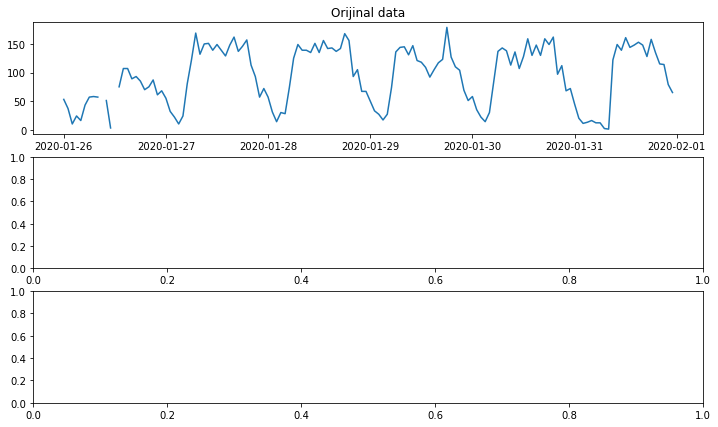

In [18]:
figure, axis = plt.subplots(3, 1,figsize=(12, 7))
axis[0].plot(data1[600:])
axis[0].set_title("Orijinal data")
axis[1].plot(data2[600:])
axis[1].set_title("eksik data")
axis[2].plot(mean[600:],color='red',linestyle='dotted')
axis[2].plot(data2[600:])
axis[2].set_title("mean")

# 2. önceki değeri atama

In [27]:
before=data2.copy()

In [28]:
before=before.fillna(method='bfill')

Text(0.5, 1.0, 'önceki değer')

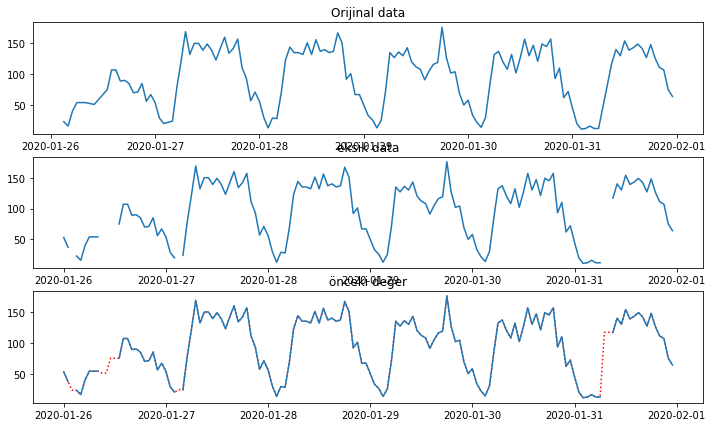

In [29]:
figure, axis = plt.subplots(3, 1,figsize=(12,7))
axis[0].plot(data1[600:])
axis[0].set_title("Orijinal data")
axis[1].plot(data2[600:])
axis[1].set_title("eksik data")
axis[2].plot(before[600:],color='red',linestyle='dotted')
axis[2].plot(data2[600:])
axis[2].set_title("önceki değer")

# 3. interpolate

In [30]:
linear_int = data2.interpolate(method='linear')

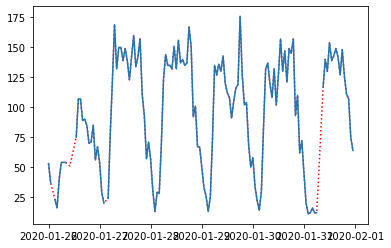

In [31]:
plt.plot(linear_int[600:],color='red',linestyle='dotted')
plt.plot(data2[600:],)
plt.show()

Text(0.5, 1.0, 'interpolasyon')

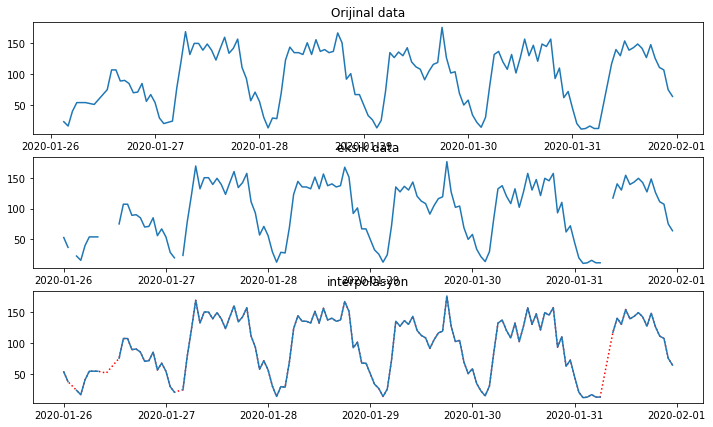

In [32]:
figure, axis = plt.subplots(3, 1,figsize=(12, 7))
axis[0].plot(data1[600:])
axis[0].set_title("Orijinal data")
axis[1].plot(data2[600:])
axis[1].set_title("eksik data")
axis[2].plot(linear_int[600:],color='red',linestyle='dotted')
axis[2].plot(data2[600:])
axis[2].set_title("interpolasyon")

# 4. The Exponential Moving average

In [33]:
dene=data2.copy()
exp=data2.copy()
dene['EWA'] = dene.ewm(alpha=0.3, adjust=False).mean()

In [34]:
for i in lis:
    exp.loc[i]['NUMBER_OF_VEHICLES']=dene.loc[i]['EWA']

Text(0.5, 1.0, 'The Exponential Moving average')

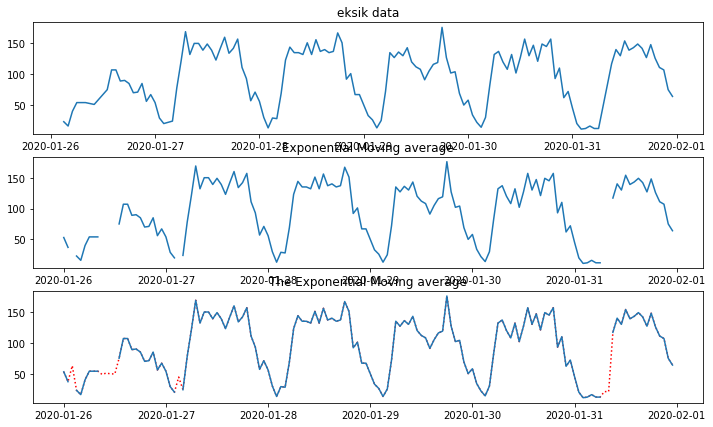

In [35]:
figure, axis = plt.subplots(3, 1,figsize=(12, 7))
axis[0].plot(data1[600:])
axis[0].set_title("eksik data")
axis[1].plot(data2[600:])
axis[1].set_title("Exponential Moving average")
axis[2].plot(exp[600:],color='red',linestyle='dotted')
axis[2].plot(data2[600:])
axis[2].set_title("The Exponential Moving average")

### Yöntem karşılaştırması

Text(0.5, 1.0, 'Exponential Moving average')

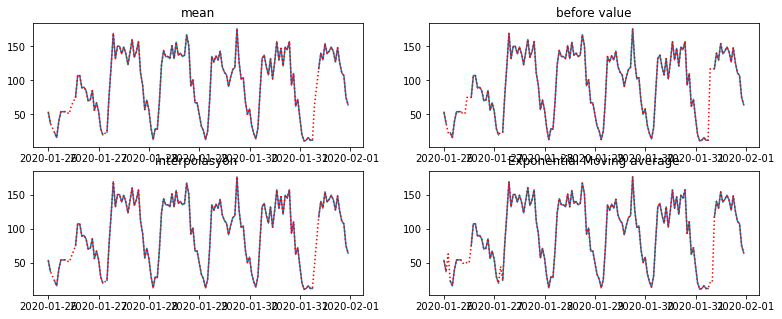

In [36]:
figure, axis = plt.subplots(2, 2,figsize=(13, 5))
axis[0][0].plot(data2[600:])
axis[0][0].plot(mean[600:],color='red',linestyle='dotted')
axis[0][0].set_title("mean")
axis[0][1].plot(data2[600:])
axis[0][1].plot(before[600:],color='red',linestyle='dotted')
axis[0][1].set_title("before value")
axis[1][0].plot(data2[600:])
axis[1][0].plot(linear_int[600:],color='red',linestyle='dotted')
axis[1][0].set_title("interpolasyon ")
axis[1][1].plot(data2[600:])
axis[1][1].plot(exp[600:],color='red',linestyle='dotted')
axis[1][1].set_title("Exponential Moving average")

Sayılsal karşılaştırmaları.

In [37]:
for i in lis:
    print("mean:%d  before:%d  interpolate:%d  " %(mean.loc[i],before.loc[i],linear_int.loc[i]))

mean:42  before:61  interpolate:42  
mean:23  before:24  interpolate:23  
mean:30  before:23  interpolate:30  
mean:52  before:51  interpolate:52  
mean:63  before:75  interpolate:59  
mean:69  before:75  interpolate:67  
mean:22  before:24  interpolate:22  
mean:64  before:117  interpolate:47  
mean:90  before:117  interpolate:82  


Ortalama ve interpolasyon değerleri yakın çıktığından dolayı daha basit olan ortalama değer atama metodunu seçtim

# Zaman serisi analizi

Zaman serileri trend, seasonality ve residual kısımlarından oluşmakta.
Trend: Uzun bir zaman aralığında değerlerin düzenli olarak aşağı veya yukarı yönde hareket etmesidir.
Seasonality: Verinin toplandığı zaman aralıklarına göre periyodik olarak gösterdiği davranıştır.
Residual: Trend ve seasonality dışında kalan kısımdır. Verinin analiz edilemeyen kısmıdır.

Verideki trend ve seasonality kısımlarını analiz edebilmek için hareketli ortalamalar metodunu kullandım. Görsel olarak çok belirli bir trend gözükmese de günlük seasonality belirgin bir şekilde görülmekte

### Moving Averages 

In [19]:
y

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01 00:00:00,58.0
2020-01-01 01:00:00,35.0
2020-01-01 02:00:00,23.0
2020-01-01 03:00:00,13.0
2020-01-01 04:00:00,13.0
...,...
2020-01-31 19:00:00,135.0
2020-01-31 20:00:00,115.0
2020-01-31 21:00:00,114.0


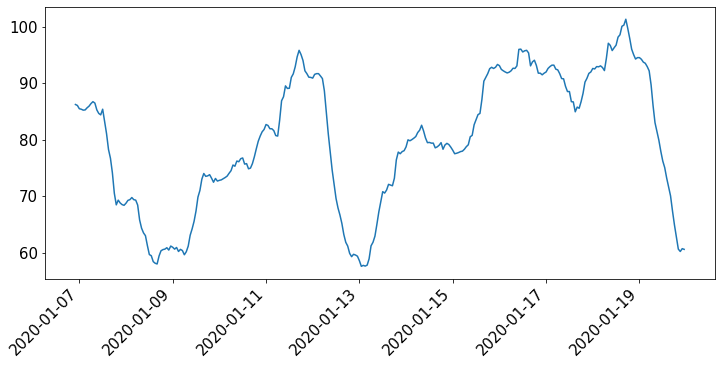

In [20]:
rol=y['2020-01-05 23:00:00':'2020-01-19 23:00:00'].rolling(window=24).mean()
plt.figure(figsize=(12, 5))
plt.rcParams["font.size"] =15
plt.xticks(rotation=45, ha='right')
plt.plot(rol)

### Exponential moving averages

In [21]:
EWA =y['2020-01-05 23:00:00':'2020-01-19 23:00:00'].ewm(alpha=0.7, adjust=False).mean()

<AxesSubplot:xlabel='DATE_TIME'>

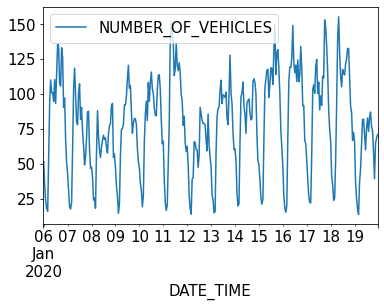

In [22]:
EWA.plot()

# Verinin ayrıştırılması

Tahminleme yapabilmemiz için veri setini modele vermeden önce stationary olduğundan emin olmalıyız. Stationary verinin zaman içinde ortalamasının ve varyansının sabit olmasıdır. Bu yüzden modele vereceğimiz veri setinin trend ve seasonality içermemesi gerekmektedir.

In [41]:
res=sm.tsa.seasonal_decompose(mean,model='additive',period=24)
trend=res.trend
season=res.seasonal
residual=res.resid

Trendin varlığı net bir şekilde seçilemese de seasonality net bir şekilde görülmektedir.

Text(0.5, 1.0, 'residual')

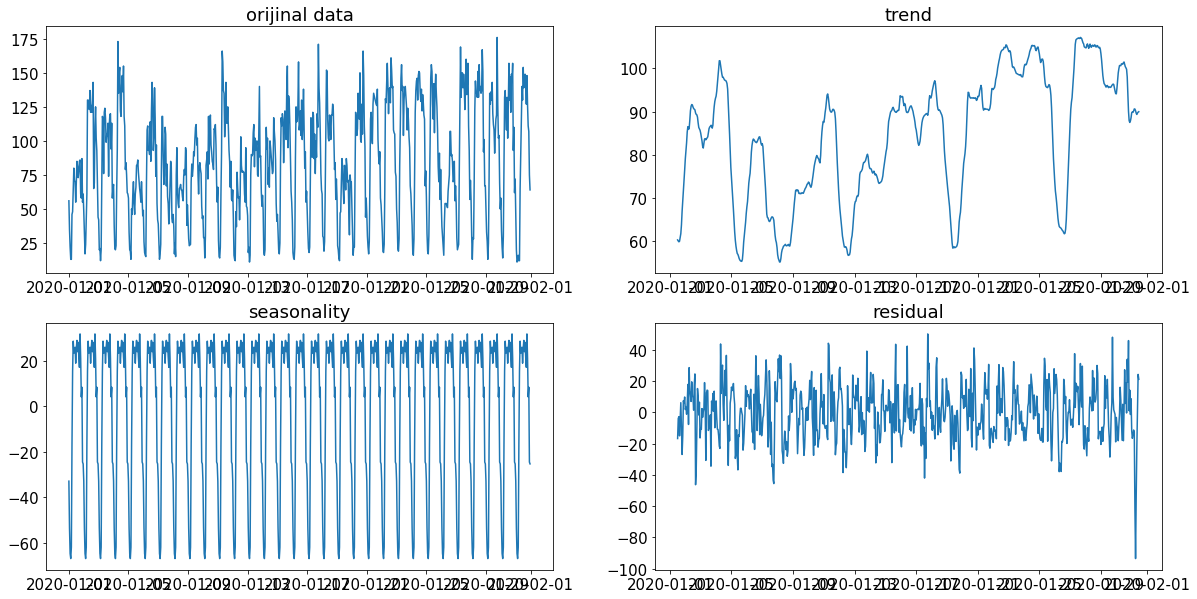

In [42]:
figure, axis = plt.subplots(2, 2,figsize=(20, 10))
axis[0][0].plot(mean)
axis[0][0].set_title("orijinal data")
axis[0][1].plot(trend)
axis[0][1].set_title("trend")
axis[1][0].plot(season)
axis[1][0].set_title("seasonality")
axis[1][1].plot(residual)
axis[1][1].set_title("residual")

In [22]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)


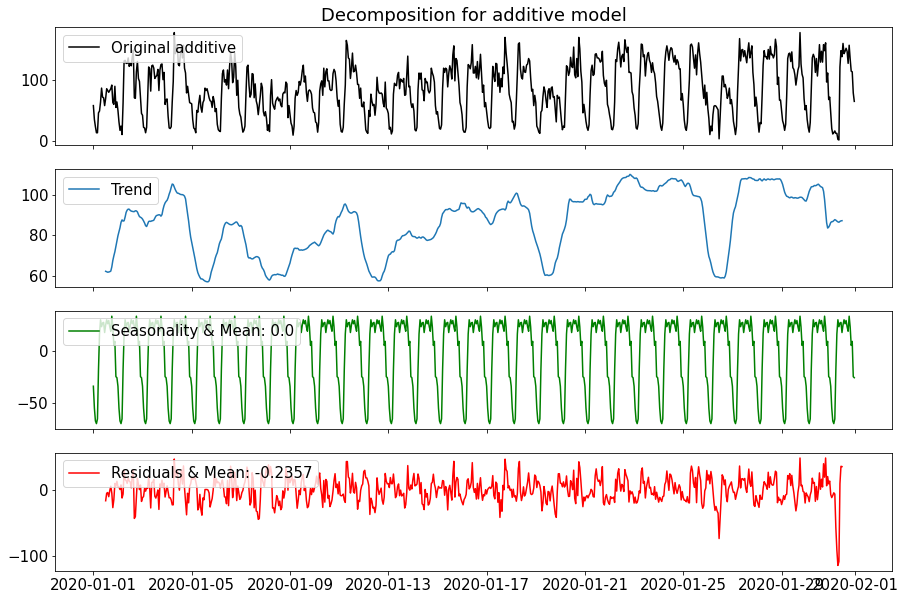

In [23]:
ts_decompose(y)

### Trend analizi

In [43]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [44]:
dp = DeterministicProcess(
    index=mean.index,  
    constant=True,       
    order=1,            
    drop=True,           
)

X = dp.in_sample()

X.head()

,const,trend
DATE_TIME,,
2020-01-01 00:00:00,1.0,1.0
2020-01-01 01:00:00,1.0,2.0
2020-01-01 02:00:00,1.0,3.0
2020-01-01 03:00:00,1.0,4.0
2020-01-01 04:00:00,1.0,5.0


In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
y = mean['NUMBER_OF_VEHICLES']  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [47]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Yukarı yönlü düzenli bir yükseliş görülmekte.

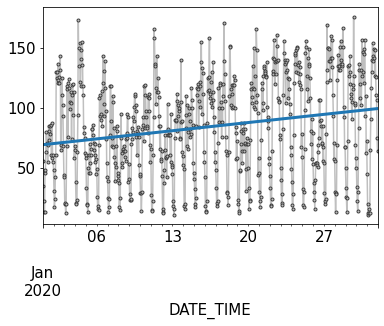

In [48]:
ax = mean.plot(color="0.75",style='.-',markeredgecolor="0.25",legend=False)
ax = y_pred.plot(linewidth=3, label="Trend")

### Seasonality

Decomposition ve moving average yöntemleri ile frekansı saatlik olan serimizin günlük seasonality içerdiğini görmüştük.

Text(0.5, 1.0, 'trend')

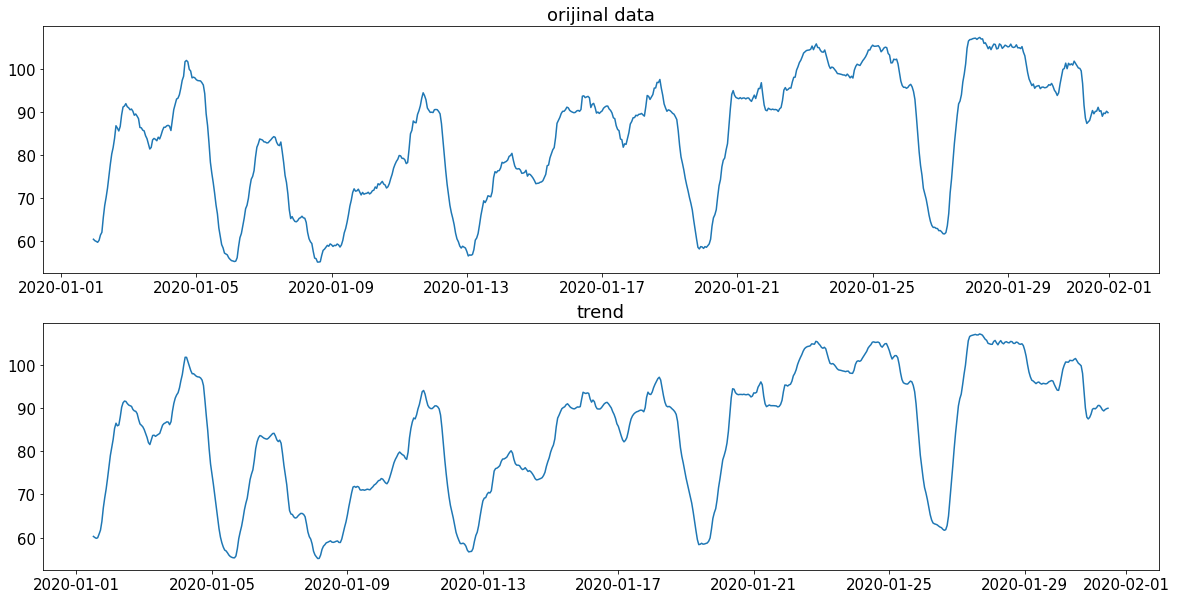

In [49]:
figure, axis = plt.subplots(2, 1,figsize=(20, 10))
axis[0].plot(rol)
axis[0].set_title("orijinal data")
axis[1].plot(trend)
axis[1].set_title("trend")

Ama aynı zamanda verimizde birden fazla seasonality hareketleri olabilir. 

In [50]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    return ax

Haftalık grafikte de görüldüğü gibi değerler haftalık periyodik oalrak cumartesi günü zirve yaparken pazar günleri de haftanın en düşük değerlerini göstermektedir.

C:\Users\Engin\AppData\Local\Temp/ipykernel_2168/3011644843.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week


<AxesSubplot:title={'center':'Seasonal Plot (week/day)'}, xlabel='day', ylabel='NUMBER_OF_VEHICLES'>

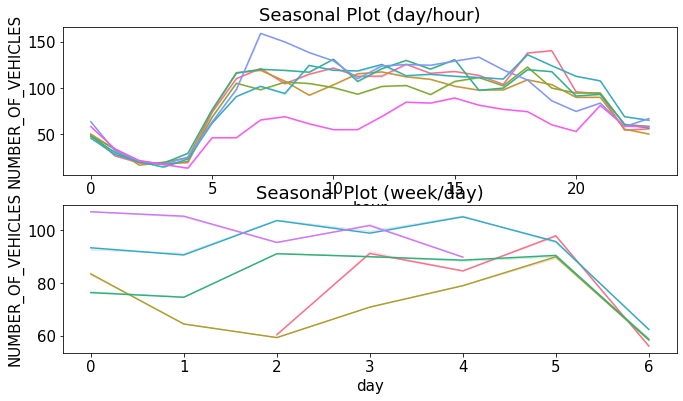

In [51]:
X = mean.copy()

X["day"] = X.index.dayofweek 
X["week"] = X.index.week  


X["hour"] = X.index.hour
X["m"] = X.index.month
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='NUMBER_OF_VEHICLES', period="day", freq="hour", ax=ax0)
seasonal_plot(X, y='NUMBER_OF_VEHICLES', period="week", freq="day", ax=ax1)

In [52]:
indices = []
for i in range(len(mean)):
    if mean.index[i].weekday() >= 5:
        indices.append(i)

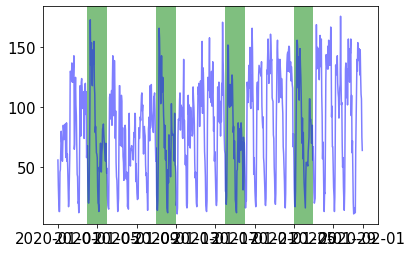

In [53]:
plt.plot(mean,color='blue', alpha=.5)
i = 0
while i < len(indices)-1:
    plt.axvspan(mean.index[indices[i]], mean.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.5)
    i += 1

In [54]:
wek=mean.copy()
wek['day']=wek.index.day
wek['hour']=wek.index.hour 
wek['week']=wek.index.weekday

# Differencing

Veri seti trend ve seasonality içerdiğinden dolayı şu anda stationary değil. Stationary hale getirmek için fark alma metodu kullanılır.

In [55]:
sh=mean-mean.shift(1)

In [56]:
rol1=sh.rolling(window=24).mean()

<AxesSubplot:xlabel='DATE_TIME'>

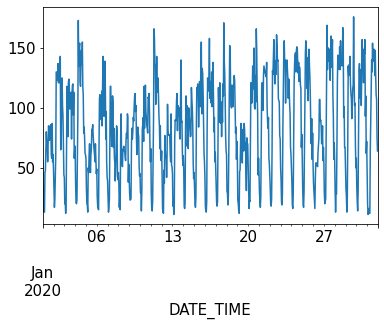

In [57]:
mean.plot(legend=False)

<AxesSubplot:xlabel='DATE_TIME'>

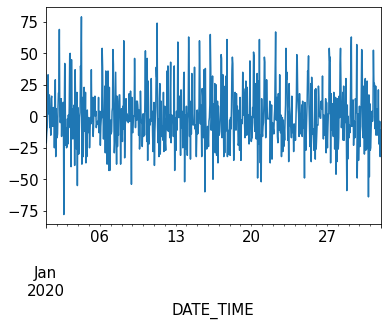

In [58]:
sh.plot(legend=False)

In [59]:
sh=sh[1:]

<AxesSubplot:xlabel='DATE_TIME'>

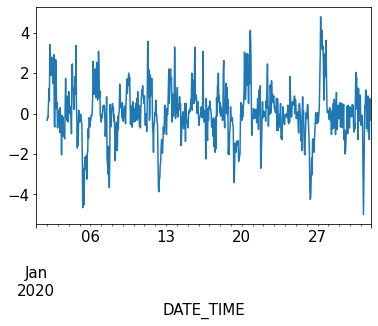

In [60]:
rol1.plot(legend=False)

In [61]:
rol1=rol1[24:]

### Anomaly kontrol

In [70]:
from prophet import Prophet

ImportError: cannot import name 'NDArray' from 'numpy.typing' (C:\Users\Engin\anaconda3\lib\site-packages\numpy\typing\__init__.py)

In [59]:
pr=mean.copy()
pr = pr.reset_index()
pr.columns = ['ds', 'y']
pr

,ds,y
0,2020-01-01 00:00:00,56.0
1,2020-01-01 01:00:00,35.0
2,2020-01-01 02:00:00,22.0
3,2020-01-01 03:00:00,13.0
4,2020-01-01 04:00:00,13.0
...,...,...
739,2020-01-31 19:00:00,126.0
740,2020-01-31 20:00:00,111.0
741,2020-01-31 21:00:00,107.0
742,2020-01-31 22:00:00,75.0


In [60]:
model = Prophet(interval_width=0.99, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
model.fit(pr)

14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing


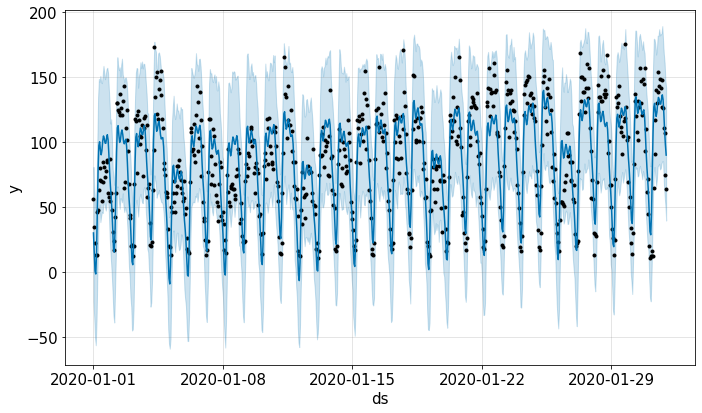

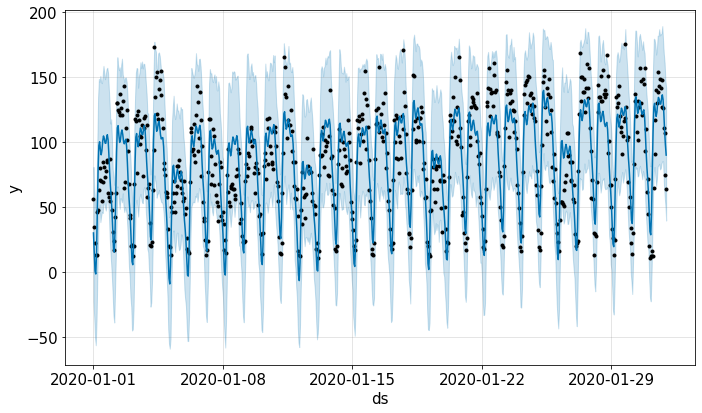

In [61]:
forecast = model.predict(pr)
model.plot(forecast)

In [62]:
model.changepoints

24    2020-01-02 00:00:00
48    2020-01-03 00:00:00
71    2020-01-03 23:00:00
95    2020-01-04 23:00:00
119   2020-01-05 23:00:00
143   2020-01-06 23:00:00
166   2020-01-07 22:00:00
190   2020-01-08 22:00:00
214   2020-01-09 22:00:00
238   2020-01-10 22:00:00
261   2020-01-11 21:00:00
285   2020-01-12 21:00:00
309   2020-01-13 21:00:00
333   2020-01-14 21:00:00
356   2020-01-15 20:00:00
380   2020-01-16 20:00:00
404   2020-01-17 20:00:00
428   2020-01-18 20:00:00
451   2020-01-19 19:00:00
475   2020-01-20 19:00:00
499   2020-01-21 19:00:00
523   2020-01-22 19:00:00
546   2020-01-23 18:00:00
570   2020-01-24 18:00:00
594   2020-01-25 18:00:00
Name: ds, dtype: datetime64[ns]

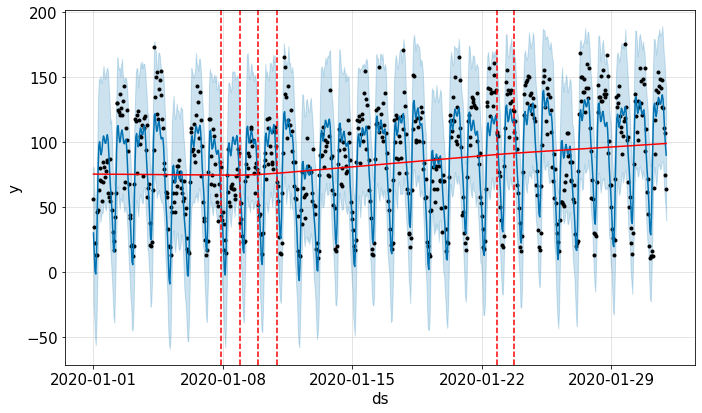

In [63]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

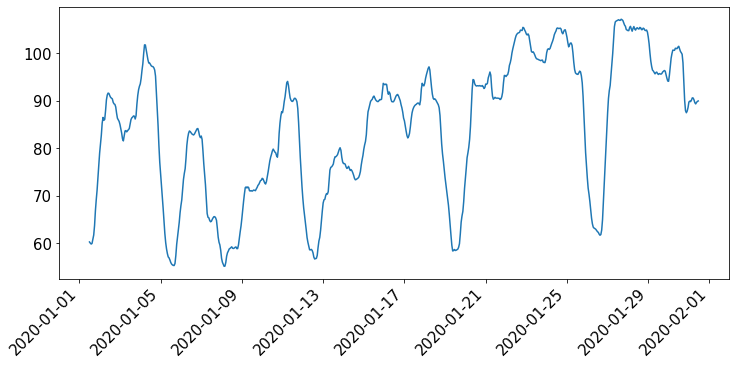

In [64]:
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45, ha='right')
plt.plot(trend)

# Stationary kontrol

In [65]:
from statsmodels.tsa.stattools import adfuller

Stationary kontrolü için Augmented Dickey-Fuller testi kullanılır. Null hipotezi non-stationary bizim hipotemiz ise stationery olduğunu iddia eder. Eğer testin sonucunda p 0.05 değerinden küçük ise null hipotezi reddedilir.

In [66]:
X = mean['NUMBER_OF_VEHICLES'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.806310
p-value: 0.002843


In [67]:
X = sh['NUMBER_OF_VEHICLES']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -17.318114
p-value: 0.000000


## Train-Test

Train veri setimiz son gün hariç olan günler. Test verisetimiz ise son gün.

In [23]:
train=y[:'2020-01-30 23:00:00']
test=y['2020-01-31 00:00:00':]

# Model hazırlığı

Arima: AutoRegressive Model (AR) Integrated (I) Moving Average Model (MA) kısımlarından oluşmaktadır. Ama bizim veri setimizde seasonality de bulunduğundan dolayı Seasonal Autoregressive Integrated Moving Average (Sarima) modeli kurmak çok daha iyi bir sonuç verecektir.

### Modelin seasonal olmayan parametreleri

#### AutoRegressive Model (AR)

Basit bir lineer regresyon modelidir. Ancak bağımsız değişkenlerimiz geçmiş tarihlerdeki değerlerimiz bağımlı değişkenimiz ise gelecek için olan tahminimiz olacak.

#### Moving Average Model (MA)

Güncel değerin geçmiş değerlerin hatasına bağlı olduğunu varsayar.

#### Integrated (I)

Trend ve seasonalityden kurtulmak için daha önce yaptığımız differencing işlemi

### Seasonal parametreler

m: Seasonal hareketlerin gerçekleştiği periyot zamanı. 
P: Seasonal autoregressive derecesi
D: Seasonal difference derecesi
Q: Seasonal moving average derecesi.

# Model parametrelerinin belirlenmesi

p -> AR modelinin derecesi 
q -> MA modelinin derecesi
d -> Difference derecesi

## Lag features

Tahmin modelleri olarak arima ve sarimax kullanacağımız için verideki geçmiş değerlerin korelasyonuna bakmamız gerekli. AR ve MA model parametrelerimizi belirlemeliyiz. 

### Auto Correlation Function (ACF)

Anlık zaman ile geçmiş zamandaki değerlerin korelasyonunun grafiğini gösterir. İstatistiksel olarak anlamlı olan değişkenleri MA modelimizin q parametresi olarak belirleriz.  

4. 5. ve 7. geçmiş değerlerimiz anlamlı şekilde anlık gözlemimiz ile negatif korelasyon içerisinde

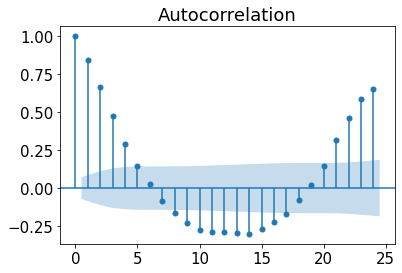

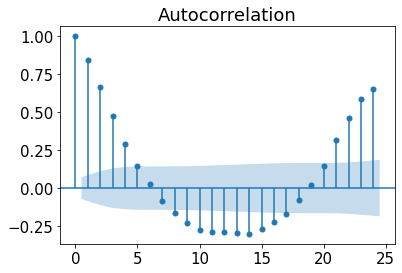

In [27]:
plot_acf(y, lags= 24)

### Partial Auto Correlation Function (PACF)

Spesifik olarak sadece 2 gözlem arasındaki korelasyonu gösterir. İstatistiksel olarak anlamlı olan değişkenleri AR modelimizin p parametresi olarak belirleriz.

Aynı şekilde PACF grafiği de 4,5 ve 7. değerler istatistiksel olarak anlamlı olup anlık değer ile direkt bir negatif korelasyon içerisindedirler.

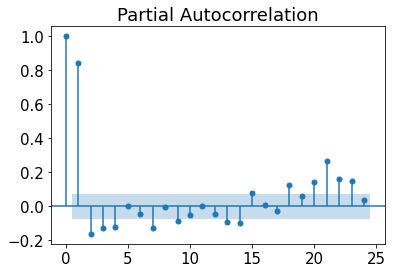

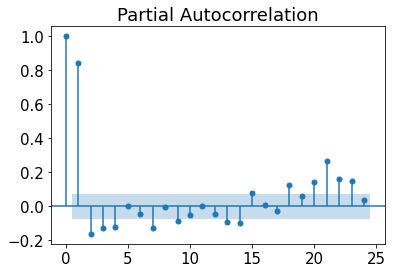

In [28]:
plot_pacf(y,method='ywm', lags= 24)

# Arima

In [32]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

In [51]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [53]:
best=arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=7428.55
ARIMA(0, 0, 1) AIC=6909.64
ARIMA(0, 0, 2) AIC=6715.08
ARIMA(0, 0, 3) AIC=6588.79
ARIMA(0, 1, 0) AIC=6593.62
ARIMA(0, 1, 1) AIC=6592.59
ARIMA(0, 1, 2) AIC=6593.92
ARIMA(0, 1, 3) AIC=6595.90
ARIMA(0, 2, 0) AIC=7033.28
ARIMA(0, 2, 1) AIC=6594.05
ARIMA(0, 2, 2) AIC=6592.88
ARIMA(0, 2, 3) AIC=6594.14
ARIMA(0, 3, 0) AIC=7800.89
ARIMA(0, 3, 1) AIC=7033.08
ARIMA(0, 3, 2) AIC=6602.55
ARIMA(0, 3, 3) AIC=6601.20
ARIMA(1, 0, 0) AIC=6547.62
ARIMA(1, 0, 1) AIC=6535.53
ARIMA(1, 0, 2) AIC=6528.06
ARIMA(1, 0, 3) AIC=6518.26
ARIMA(1, 1, 0) AIC=6592.45
ARIMA(1, 1, 1) AIC=6594.29
ARIMA(1, 1, 2) AIC=6529.88
ARIMA(1, 1, 3) AIC=6522.27
ARIMA(1, 2, 0) AIC=6848.46
ARIMA(1, 2, 1) AIC=6592.72
ARIMA(1, 2, 2) AIC=6594.54
ARIMA(1, 2, 3) AIC=6593.63
ARIMA(1, 3, 0) AIC=7389.61
ARIMA(1, 3, 1) AIC=6849.27
ARIMA(1, 3, 2) AIC=6600.93
ARIMA(1, 3, 3) AIC=6609.09
ARIMA(2, 0, 0) AIC=6531.22
ARIMA(2, 0, 1) AIC=6506.61
ARIMA(2, 0, 2) AIC=6508.58
ARIMA(2, 0, 3) AIC=6510.37
ARIMA(2, 1, 0) AIC=6594.10


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) AIC=6593.22
ARIMA(2, 1, 2) AIC=6505.47


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) AIC=6497.31
ARIMA(2, 2, 0) AIC=6785.43
ARIMA(2, 2, 1) AIC=6594.33
ARIMA(2, 2, 2) AIC=6593.52


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) AIC=6570.11
ARIMA(2, 3, 0) AIC=7171.94
ARIMA(2, 3, 1) AIC=6786.85
ARIMA(2, 3, 2) AIC=6602.42


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 3, 3) AIC=6601.97
ARIMA(3, 0, 0) AIC=6520.10
ARIMA(3, 0, 1) AIC=6508.58
ARIMA(3, 0, 2) AIC=6510.60
ARIMA(3, 0, 3) AIC=6512.56
ARIMA(3, 1, 0) AIC=6595.81
ARIMA(3, 1, 1) AIC=6513.79
ARIMA(3, 1, 2) AIC=6496.25


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) AIC=6496.16
ARIMA(3, 2, 0) AIC=6771.97
ARIMA(3, 2, 1) AIC=6596.08


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 2) AIC=6595.29


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) AIC=6567.48
ARIMA(3, 3, 0) AIC=7089.65
ARIMA(3, 3, 1) AIC=6773.68


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 3, 2) AIC=6654.62
ARIMA(3, 3, 3) AIC=6604.39
Best ARIMA(3, 1, 3) AIC=6496.16


C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
arima_model = ARIMA(train, order=best).fit()
y_pred = arima_model.forecast(24)

C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [56]:
y_pred

2020-01-31 00:00:00     67.469578
2020-01-31 01:00:00     68.636822
2020-01-31 02:00:00     68.836056
2020-01-31 03:00:00     73.737727
2020-01-31 04:00:00     76.646451
2020-01-31 05:00:00     83.232619
2020-01-31 06:00:00     86.908096
2020-01-31 07:00:00     93.447480
2020-01-31 08:00:00     96.440662
2020-01-31 09:00:00    101.805867
2020-01-31 10:00:00    103.322174
2020-01-31 11:00:00    107.039309
2020-01-31 12:00:00    106.895004
2020-01-31 13:00:00    109.027295
2020-01-31 14:00:00    107.481589
2020-01-31 15:00:00    108.430521
2020-01-31 16:00:00    105.974372
2020-01-31 17:00:00    106.272009
2020-01-31 18:00:00    103.436610
2020-01-31 19:00:00    103.579474
2020-01-31 20:00:00    100.801348
2020-01-31 21:00:00    101.149440
2020-01-31 22:00:00     98.703435
2020-01-31 23:00:00     99.445061
Freq: H, Name: predicted_mean, dtype: float64

In [62]:
def plot_pred(train, test, y_pred):
    train.plot(legend=True, label="TRAIN")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

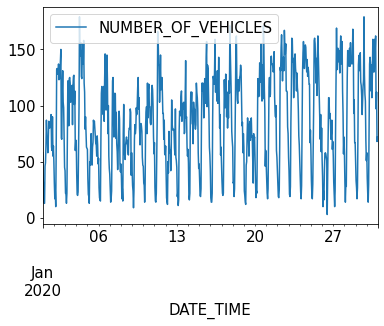

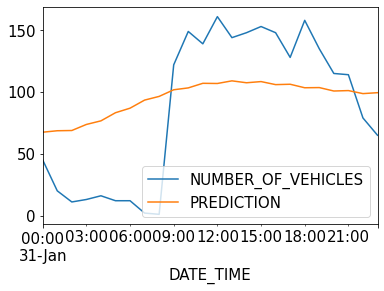

In [63]:
plot_pred(train,test,y_pred)

# Sarima

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit()
                y_pred_test = sarima_model.forecast(24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order


In [28]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMANonexNone12 - MAE:inf


### Auto Arima

In [29]:
auto_arima(train,m=24,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=12.60 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=6595.622, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=6406.853, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=6475.823, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=6593.622, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=6594.445, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=6361.973, Time=5.75 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=11.22 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=6382.210, Time=2.58 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=6352.880, Time=5.76 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=6405.104, Time=1.88 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=15.79 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 24)   Log Likelihood               -3170.440
Date:                            Fri, 26 May 2023   AIC                           6350.880
Time:                                    02:10:40   BIC                           6373.769
Sample:                                         0   HQIC                          6359.717
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2156      0.034     -6.291      0.000      -0.283      -0.148
ar.L2         -0.1284      0.033     -3.860      0.000      -0.194      -0.063
ar.S.L24       0.3991      0.034     11.679      0.000       0.332       0.466
ar.S.L48       0.2888      0.035      8.311      0.000       0.221       0.357
sigma2       388.6289     16.775     23.168      0.000     355.751     421.506
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.35
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.24
Prob(H) (two-sided):                  0.41   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto arima en iyi parametreler olarak p=3 d=1 q=0 P=2 D=0 Q=0 belirledi

In [31]:
p=2
d=1
q=0
P=2
D=0
Q=0
m=24

In [32]:
mod=SARIMAX(train,order=(p,d,q),seasonal_order=(P,D,Q,m))
res=mod.fit()
pred1=res.predict(start=test.index[0],end=test.index[-1])

C:\Users\Engin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='DATE_TIME'>

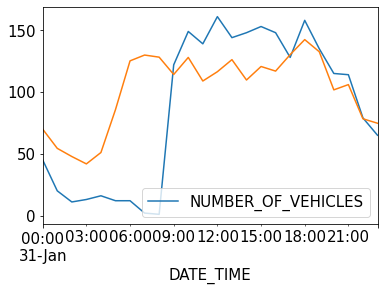

In [33]:
test.plot()
pred1.plot()

In [34]:
Arima_mae = mean_absolute_error(test, pred1)
Arima_mae

36.5392160182627

# Parametre

In [76]:
import itertools
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
p=range(0,5)
q=range(0,5)
d=range(0,2)
P=range(0,3)
Q=range(0,3)
D=range(0,2)
comb=list(itertools.product(p,d,q,P,D,Q))
pdq=[]
error=[]

In [77]:
comb[0]

(0, 0, 0, 0, 0, 0)

In [78]:
for i in comb:
    model=SARIMAX(train,order=(i[0],i[1],i[2]),seasonal_order=(i[3],i[4],i[5],m))
    pred=model.predict(start=len(train),end=(len(data3)-1))
    MSE = mean_squared_error(test,pred)
    pdq.append(i)
    error.append(MSE)

TypeError: predict() missing 1 required positional argument: 'params'

In [79]:
d={'order':pdq,'MSE':error}
df=pd.DataFrame(d)
df.sort_values(by=['MSE'],ascending=True)

,order,MSE


## Prophet

In [80]:
pr=train.copy()
pr['ds']=train.index
pr=pr.reset_index(drop=True)
pr = pr.rename(columns={'NUMBER_OF_VEHICLES': 'y'})

In [81]:
pr1=test.copy()
pr1['ds']=test.index
pr1=pr1.reset_index(drop=True)
pr1 = pr1.rename(columns={'NUMBER_OF_VEHICLES': 'y'})

In [82]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
model.fit(pr)

14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
len(pr),len(pr1)

(595, 149)

In [84]:
forecast = model.predict(pr1)

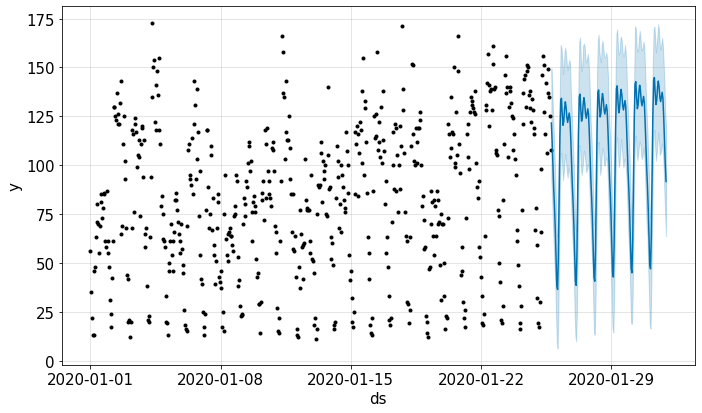

In [85]:
fig1 = model.plot(forecast)

In [86]:
pred2=forecast['yhat']
pred2.index=pr1.index

<AxesSubplot:>

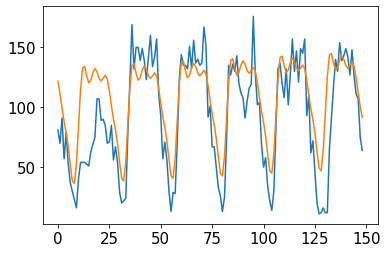

In [87]:
pr1['y'].plot()
pred2.plot()

In [88]:
Prophet_mae = mean_absolute_error(pr1['y'], forecast['yhat'])
Prophet_mae

23.57552699722264

## Multiple Seasonality Prophet

In [108]:
df=train.copy()
df_test=test.copy()

In [109]:
df['ds']=df.index
df=df.reset_index(drop=True)
df = df.rename(columns={'NUMBER_OF_VEHICLES': 'y'})

In [110]:
df_test['ds']=df_test.index
df_test=df_test.reset_index(drop=True)
df_test = df_test.rename(columns={'NUMBER_OF_VEHICLES': 'y'})

In [111]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek > 4)

In [112]:
df['on_season'] = df['ds'].apply(is_weekend)
df['off_season'] = ~df['ds'].apply(is_weekend)

In [113]:
future=df_test[['ds']]

In [114]:
m = Prophet(daily_seasonality=True,weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
future['on_season'] = future['ds'].apply(is_weekend)
future['off_season'] = ~future['ds'].apply(is_weekend)

forecast = m.fit(df).predict(future)


14:55:41 - cmdstanpy - INFO - Chain [1] start processing
14:55:41 - cmdstanpy - INFO - Chain [1] done processing


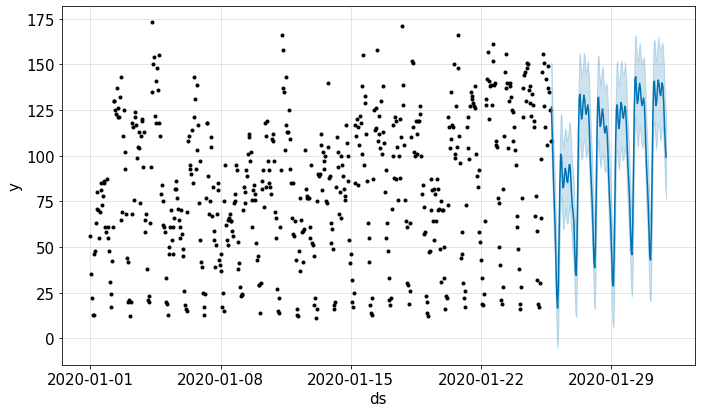

In [115]:
fig1 = model.plot(forecast)

In [116]:
pred3=forecast['yhat']
pred3.index=test.index

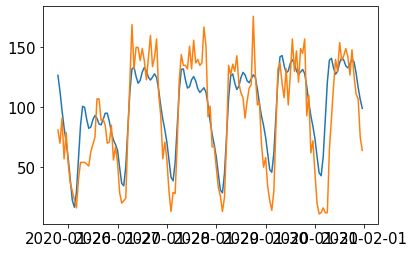

In [117]:
plt.plot(pred3)
plt.plot(test)

In [118]:
multi_Prophet_mae = mean_absolute_error(test, forecast['yhat'])
multi_Prophet_mae

19.341375355488726

## Tbats

In [35]:
from sktime.forecasting.tbats import TBATS

ModuleNotFoundError: No module named 'sktime'

In [ ]:
fh=np.array(range(0,len(test)))
forecaster = TBATS(use_box_cox=True,
                   use_trend=True,
                   use_damped_trend=False,
                   sp=[24, 168])
forecaster.fit(train)
y_pred_TBATS = forecaster.predict(fh)

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(test)
plt.plot(y_pred_TBATS)

In [ ]:
Tbats_mae = mean_absolute_error(test, y_pred_TBATS)
Tbats_mae

# Lightgbm